In [1]:
import numpy as np 
import pandas as pd 
import skimage, os
import SimpleITK as sitk
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import os
import zarr

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras import backend as K
K.set_image_dim_ordering('th') 

from sklearn.model_selection import train_test_split
import time
import gc
import warnings
warnings.filterwarnings('ignore')
from utils_3d import *

from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, merge, UpSampling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.layers.convolutional import Convolution3D, MaxPooling3D, UpSampling3D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import SpatialDropout3D
from keras.models import load_model



def load_3d_data(start, end, size = 168, size_3d = 136, normalize = False):
    
    if normalize:
        mask_path = '/home/w/DS_Projects/Kaggle/DS Bowl 2017/LUNA/Data/nodules_3d/lung_preprocessed2/'
        nodules_path = '/home/w/DS_Projects/Kaggle/DS Bowl 2017/LUNA/Data/nodules_3d/nodule_mask/'
        patients = sorted([x for x in os.listdir(mask_path) if '.npy' in x])[start:end]
        masks = np.full((len(patients), 1, size_3d, size, size), -0.25).astype('float32')
        nodules = np.zeros((len(patients), 1, size_3d, size, size)).astype('float32')
    else:
        mask_path = '/home/w/DS_Projects/Kaggle/DS Bowl 2017/LUNA/Data/nodules_3d/lung_mask/'
        nodules_path = '/home/w/DS_Projects/Kaggle/DS Bowl 2017/LUNA/Data/nodules_3d/nodule_mask/'
        patients = sorted([x for x in os.listdir(mask_path) if '.npy' in x])[start:end]
        masks = np.full((len(patients), 1, size_3d, size, size), threshold_min).astype('float32')
        nodules = np.zeros((len(patients), 1, size_3d, size, size)).astype('float32')
    print('Loading {} patients,'.format(len(patients)), 'Start: {}, end: {}'.format(start, end))
    
    for i in range(len(patients)):
        mask = np.load(mask_path + patients[i]).astype('float32')
        mask = mask.swapaxes(1, 0)
        nod = np.load(nodules_path + patients[i]).astype('float32')
        nod = nod.swapaxes(1, 0)
        num_slices = mask.shape[1]
        offset = (size_3d - num_slices)
        if offset == 0:
            masks[i, :, :, :, :] = mask[:, :, :, :]
            nodules[i, :, :, :, :] = nod[:, :, :, :]
        if offset > 0:
            begin_offset = int(np.round(offset/2))
            end_offset = int(offset - begin_offset)
            masks[i, :, begin_offset:-end_offset, :, :] = mask[:, :, :, :]
            nodules[i, :, begin_offset:-end_offset, :, :] = nod[:, :, :, :]
        if offset < 0:
            print('{} slices lost due to size restrictions'.format(offset))
            offset = -(size_3d - num_slices)
            begin_offset = int(np.round(offset/2))
            end_offset = int(offset - begin_offset)
            masks[i, :, :, :, :] = mask[:, begin_offset:-end_offset, :, :]
            nodules[i, :, :, :, :] = nod[:, begin_offset:-end_offset, :, :]

    return masks, nodules


def unet_model():
    
    inputs = Input(shape=(1, size_3d, img_size, img_size))
    conv1 = Convolution3D(width, 3, 3, 3, activation = 'relu', border_mode='same')(inputs)
    conv1 = BatchNormalization(axis = 1)(conv1)
    conv1 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(conv1)
    conv1 = BatchNormalization(axis = 1)(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2), border_mode='same')(conv1)
    
    conv2 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(pool1)
    conv2 = BatchNormalization(axis = 1)(conv2)
    conv2 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(conv2)
    conv2 = BatchNormalization(axis = 1)(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2), border_mode='same')(conv2)

    conv3 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(pool2)
    conv3 = BatchNormalization(axis = 1)(conv3)
    conv3 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(conv3)
    conv3 = BatchNormalization(axis = 1)(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2), border_mode='same')(conv3)
    
    conv4 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(pool3)
    conv4 = BatchNormalization(axis = 1)(conv4)
    conv4 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(conv4)
    conv4 = BatchNormalization(axis = 1)(conv4)
    conv4 = Convolution3D(width*16, 3, 3, 3, activation = 'relu', border_mode='same')(conv4)
    conv4 = BatchNormalization(axis = 1)(conv4)

    up5 = merge([UpSampling3D(size=(2, 2, 2))(conv4), conv3], mode='concat', concat_axis=1)
    conv5 = SpatialDropout3D(0.2)(up5)
    conv5 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(conv5)
    conv5 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(conv5)
    
    up6 = merge([UpSampling3D(size=(2, 2, 2))(conv5), conv2], mode='concat', concat_axis=1)
    conv6 = SpatialDropout3D(0.2)(up6)
    conv6 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(conv6)
    conv6 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(conv6)

    up7 = merge([UpSampling3D(size=(2, 2, 2))(conv6), conv1], mode='concat', concat_axis=1)
    conv7 = SpatialDropout3D(0.2)(up7)
    conv7 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(conv7)
    conv7 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(conv7)
    conv8 = Convolution3D(1, 1, 1, 1, activation='sigmoid')(conv7)

    model = Model(input=inputs, output=conv8)
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model


def weight_by_class_balance(truth, classes=None):
    if classes is None:
        classes = np.unique(truth)
    weight_map = np.zeros_like(truth, dtype=np.float32)
    total_amount = np.product(truth.shape)
    for c in classes:
        class_mask = np.where(truth==c,1,0)
        class_weight = 1/((np.sum(class_mask)+1e-8)/total_amount)
        weight_map += (class_mask*class_weight)#/total_amount
    return weight_map
    


Using TensorFlow backend.


In [10]:
def unet_fit(name, size, max_slices, normalize = True, weighting = False,
             augment = False, load_check = False, check_name = None):
    
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, 
                                   verbose = 1),
    ModelCheckpoint('/home/w/DS_Projects/Kaggle/DS Bowl 2017/Scripts/LUNA/CNN/Checkpoints/{}.h5'.format(name), 
                        monitor='val_loss', 
                        verbose = 0, save_best_only = True)]
    t = time.time()
  
    model = unet_model()
    lung_masks, nodule_masks = load_3d_data(start = 0, end = end, size_3d = size_3d, size = size,
                                           normalize = normalize)
    if weighting:
        print('Loss function weighted.')
        for i in range(nodule_masks.shape[0]):
            nodule_masks[i, :, :, :, :] = weight_by_class_balance(nodule_masks[i, :, :, :, :])
    
    if augment:
        print('Using augmented data')
        scans_g, masks_g = augmentation(lung_masks, nodules_masks, 350)
        X_train, X_valid, y_train, y_valid = train_test_split(scans_g, masks_g, test_size = 0.2, random_state = 111)
        print('Training data shape: {}'.format(X_train.shape), '\n', 
              'Validation data shape: {}'.format(X_valid.shape))
        del lung_masks, nodule_masks, scans_g, masks_g
        gc.collect()
        print('Time it took to augment and split the data:', time.time() - t, '\n')
        
    else:
        print('Using not augmented data')
        X_train, X_valid, y_train, y_valid = train_test_split(lung_masks, nodule_masks, test_size = 0.2, random_state = 111)
        print('Training data shape: {}'.format(X_train.shape), '\n', 
              'Validation data shape: {}'.format(X_valid.shape))

        del lung_masks, nodule_masks
        gc.collect()
    
    model.fit(X_train, y_train, batch_size = 1, nb_epoch = epochs, verbose=1, shuffle=True, 
              validation_data = (X_valid, y_valid), callbacks = callbacks)
    
    return model


In [11]:

threshold_min = -2000
smooth = 1.0
end = 50

size_3d = 136
width = 8
img_size = 168

img_rows = img_size
img_cols = img_size


In [12]:
epochs = 50

max_slices, full_slices = get_max_slices(0, end)
model = unet_fit('3D_UNet_normalized_50pats_gpu1', img_size, max_slices, normalize = False)


Number of max slices in CT image: 122
Number of 2D slices in CT image: 5266
('Loading 50 patients,', 'Start: 0, end: 50')
Using not augmented data
('Training data shape: (40, 1, 136, 168, 168)', '\n', 'Validation data shape: (10, 1, 136, 168, 168)')
Train on 40 samples, validate on 10 samples
Epoch 1/50
40/40 [==============================] - 85s - loss: -2.0458e-05 - dice_coef: 2.0458e-05 - val_loss: -9.1958e-05 - val_dice_coef: 9.1958e-05

KeyboardInterrupt: 

In [5]:
ms2, nds2 = load_3d_data(50, 55)

('Loading 5 patients,', 'Start: 50, end: 55')


In [6]:
preds = model.predict(ms2, batch_size = 2)

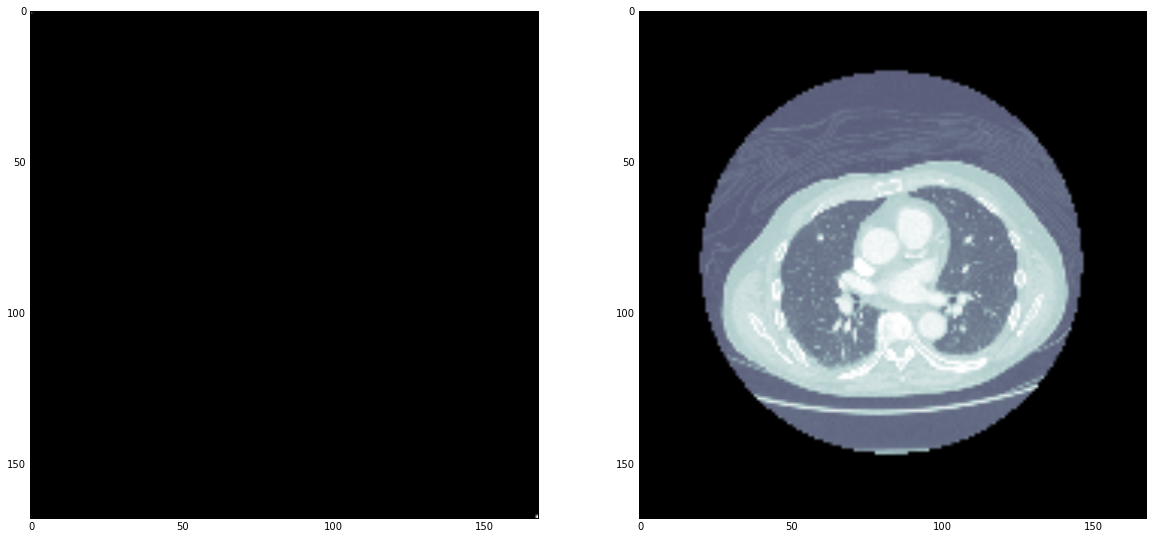

In [8]:
print_mask(preds[2][0][64], ms2[2][0][64])

In [9]:
np.max(preds)

0.0010509474